<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [44]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# 1. Data Cleaning

In [2]:
# Load the data
house = pd.read_csv('../housing.csv')
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 300)
print house.shape
house.head(15)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [3]:
#Gets the column names

In [4]:
#Checks out the columns attributes 
house.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


1. Perform any cleaning

In [5]:
#checks out how many null values there are in the data
nulls = house.isnull().sum()
nulls.sort_values(ascending=False).head(19)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

As we can see, PoolQC, MiscFeature, Alley and Fence got so many null values, so we can get rid of them. 
Also I won't need the PoolArea related with PoolQC and neither Id
Utilities has just one row with a different value so I drop that row and the column 

In [6]:
#Drops columns
house.drop(['Id','PoolQC','MiscFeature','Alley', 'Fence'],axis=1, inplace=True)
house.head(15)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939.0,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,0,1,2008,WD,Normal,118000


# 2. Removing any houses that are not residential from the dataset.

In [7]:
# Creates a list for residential
residential = ["RH", "RL", "RP", "RM", "FV"]
# Removes the other observations
house=house[house["MSZoning"].isin(residential)]


There is just 2 values in the Categorical variable "Utilities", one of them just appears in one row, so we can 
delete it and also the column. 
Same happens with the Categorical Variable 'Street', we find just 4 rows with the value Grvl, so we can remove the 
rows and the column.

In [8]:
#gets the rows where "Utilities"=="NoSeWa
house[house["Utilities"]=="NoSeWa"]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
944,20,RL,NaN,14375,Pave,IR1,Lvl,NoSeWa,CulDSac,Gtl,Timber,Norm,Norm,1Fam,SLvl,6,6,1958,1958,Gable,CompShg,HdBoard,HdBoard,BrkFace,541.0,TA,TA,CBlock,TA,TA,No,GLQ,111,Rec,354,354,819,GasA,Gd,Y,FuseA,1344,0,0,1344,0,1,1,0,3,1,Gd,7,Typ,1,Gd,Basment,1958.0,RFn,2,525,TA,TA,Y,0,118,0,0,233,0,0,1,2009,COD,Abnorml,137500


In [9]:
#gets the rows where Street=="Grvl"
house[house.Street=="Grvl"]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
52,90,RM,110.0,8472,Grvl,IR2,Bnk,AllPub,Corner,Mod,IDOTRR,RRNn,Norm,Duplex,1Story,5,5,1963,1963,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,TA,CBlock,Gd,TA,Gd,LwQ,104,GLQ,712,0,816,GasA,TA,N,SBrkr,816,0,0,816,1,0,1,0,2,1,TA,5,Typ,0,NaN,CarPort,1963.0,Unf,2,516,TA,TA,Y,106,0,0,0,0,0,0,5,2010,WD,Normal,110000
335,190,RL,NaN,164660,Grvl,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.0,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,700,8,2008,WD,Normal,228950
582,90,RL,81.0,11841,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,SFoyer,6,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,BrkFace,104.0,TA,Gd,CBlock,Gd,TA,Av,GLQ,816,Unf,0,0,816,GasA,TA,Y,SBrkr,816,0,0,816,1,0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,32,0,0,0,0,0,5,2007,WD,Normal,118500
1184,20,RL,50.0,35133,Grvl,Reg,Lvl,AllPub,Inside,Mod,Timber,Norm,Norm,1Fam,1Story,5,4,1963,1963,Hip,CompShg,MetalSd,MetalSd,BrkFace,226.0,TA,TA,CBlock,TA,TA,Gd,Rec,1159,Unf,0,413,1572,GasA,Gd,Y,SBrkr,1572,0,0,1572,1,0,1,1,3,1,TA,5,Typ,2,TA,2Types,1963.0,RFn,3,995,TA,TA,Y,0,263,0,0,263,0,0,5,2007,WD,Normal,186700


In [10]:
#Drops the rows
house.drop(house[house.Utilities=="NoSeWa"].index, inplace= True)
house.drop(house[house.Street=="Grvl"].index, inplace= True)

In [11]:
house.drop(['Utilities','Street', 'GarageYrBlt'],axis=1, inplace=True)

In [12]:
house.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1445.000000,1188.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1437.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000
mean,56.816609,70.026936,10397.975779,6.116955,5.583391,1971.606228,1985.109343,104.161447,444.323183,46.193080,568.737024,1059.253287,1164.535640,348.480969,5.550173,1518.566782,0.425606,0.056747,1.570242,0.385467,2.870588,1.046367,6.524567,0.615225,1.770242,473.140484,94.617993,46.413149,21.611073,3.444983,14.805536,2.787543,43.031142,6.317647,2007.811073,181742.571626
std,42.152575,24.294999,9148.138798,1.374288,1.108142,30.066396,20.551919,181.366399,455.988749,160.925421,442.622447,439.469141,386.735488,437.441321,47.013021,525.344051,0.517861,0.237348,0.549566,0.503653,0.815705,0.220006,1.626558,0.643562,0.744193,212.235138,124.788644,65.035311,60.930842,29.467138,55.307228,40.384456,498.192386,2.698260,1.326645,79255.158822
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,20.000000,59.000000,7535.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,224.000000,796.000000,884.000000,0.000000,0.000000,1132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,50.000000,70.000000,9490.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,0.000000,480.000000,992.000000,1088.000000,0.000000,0.000000,1466.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,479.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163990.000000
75%,70.000000,80.000000,11600.000000,7.000000,6.000000,2001.000000,2004.000000,166.000000,712.000000,0.000000,808.000000,1300.000000,1392.000000,729.000000,0.000000,1779.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [13]:
#Removing Outliers
import numpy
count = 0
for col in house.columns:
    elements = house[col]
    if elements.dtype != 'object':       
        mean = numpy.mean(elements, axis=0)
        sd = numpy.std(elements, axis=0)
        upper= mean + 3 * sd
        lower= mean - 3 * sd
        out = house[(elements>upper) | (elements<lower)].index.values
        house = house.drop(out,axis=0)
        count = count + len(out)
print 'Outliers removed:',count

Outliers removed: 483


In [14]:
#There are many null values in the Categorical variables, so I can create a None value for them

In [15]:
#Creates a list with the categorical features
categorical_columns = ['FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 
                       'GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 
                       'MasVnrType', 'Electrical', 'Neighborhood']
#FIll the nan values with "none"
house[categorical_columns] = house[categorical_columns].fillna(value='None')
nulls = house.isnull().sum()
nulls.sort_values(ascending=False).head(19)

LotFrontage     169
MasVnrArea        6
SalePrice         0
BsmtQual          0
Exterior2nd       0
MasVnrType        0
ExterQual         0
ExterCond         0
Foundation        0
BsmtCond          0
RoofMatl          0
BsmtExposure      0
BsmtFinType1      0
BsmtFinSF1        0
BsmtFinType2      0
BsmtFinSF2        0
BsmtUnfSF         0
Exterior1st       0
RoofStyle         0
dtype: int64

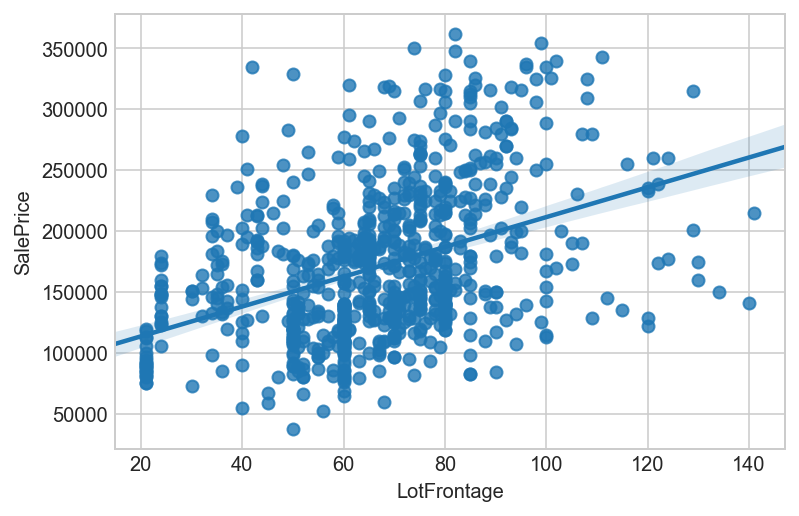

In [16]:
#Visualazing the scatter plot "sale Price" against "LotFrontage"
sns.regplot(x="LotFrontage", y="SalePrice", data=house );
sns.set(rc={"figure.figsize": (10, 10)})
sns.set(font_scale=1)

In [17]:
#Replaces null values in the numercial variables with the value 0
mylist = list(house.select_dtypes(include=['object']).columns)
Numerical_values = [c for c in house.columns if c not in mylist]
house[Numerical_values] =house[Numerical_values].fillna(value=0)
Numerical_df = house[Numerical_values]
Numerical_df.head(15)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
6,20,75.0,10084,8,5,2004,2005,186.0,1369,0,317,1686,1694,0,0,1694,1,0,2,0,3,1,7,1,2,636,255,57,0,0,0,0,0,8,2007,307000
10,20,70.0,11200,5,5,1965,1965,0.0,906,0,134,1040,1040,0,0,1040,1,0,1,0,3,1,5,0,1,384,0,0,0,0,0,0,0,2,2008,129500
13,20,91.0,10652,7,5,2006,2007,306.0,0,0,1494,1494,1494,0,0,1494,0,0,2,0,3,1,7,1,3,840,160,33,0,0,0,0,0,8,2007,279500
14,20,0.0,10920,6,5,1960,1960,212.0,733,0,520,1253,1253,0,0,1253,1,0,1,1,2,1,5,1,1,352,0,213,176,0,0,0,0,5,2008,157000
15,45,51.0,6120,7,8,1929,2001,0.0,0,0,832,832,854,0,0,854,0,0,1,0,2,1,5,0,2,576,48,112,0,0,0,0,0,7,2007,132000
16,20,0.0,11241,6,7,1970,1970,180.0,578,0,426,1004,1004,0,0,1004,1,0,1,0,2,1,5,1,2,480,0,0,0,0,0,0,700,3,2010,149000
18,20,66.0,13695,5,5,2004,2004,0.0,646,0,468,1114,1114,0,0,1114,1,0,1,1,3,1,6,0,2,576,0,102,0,0,0,0,0,6,2008,159000


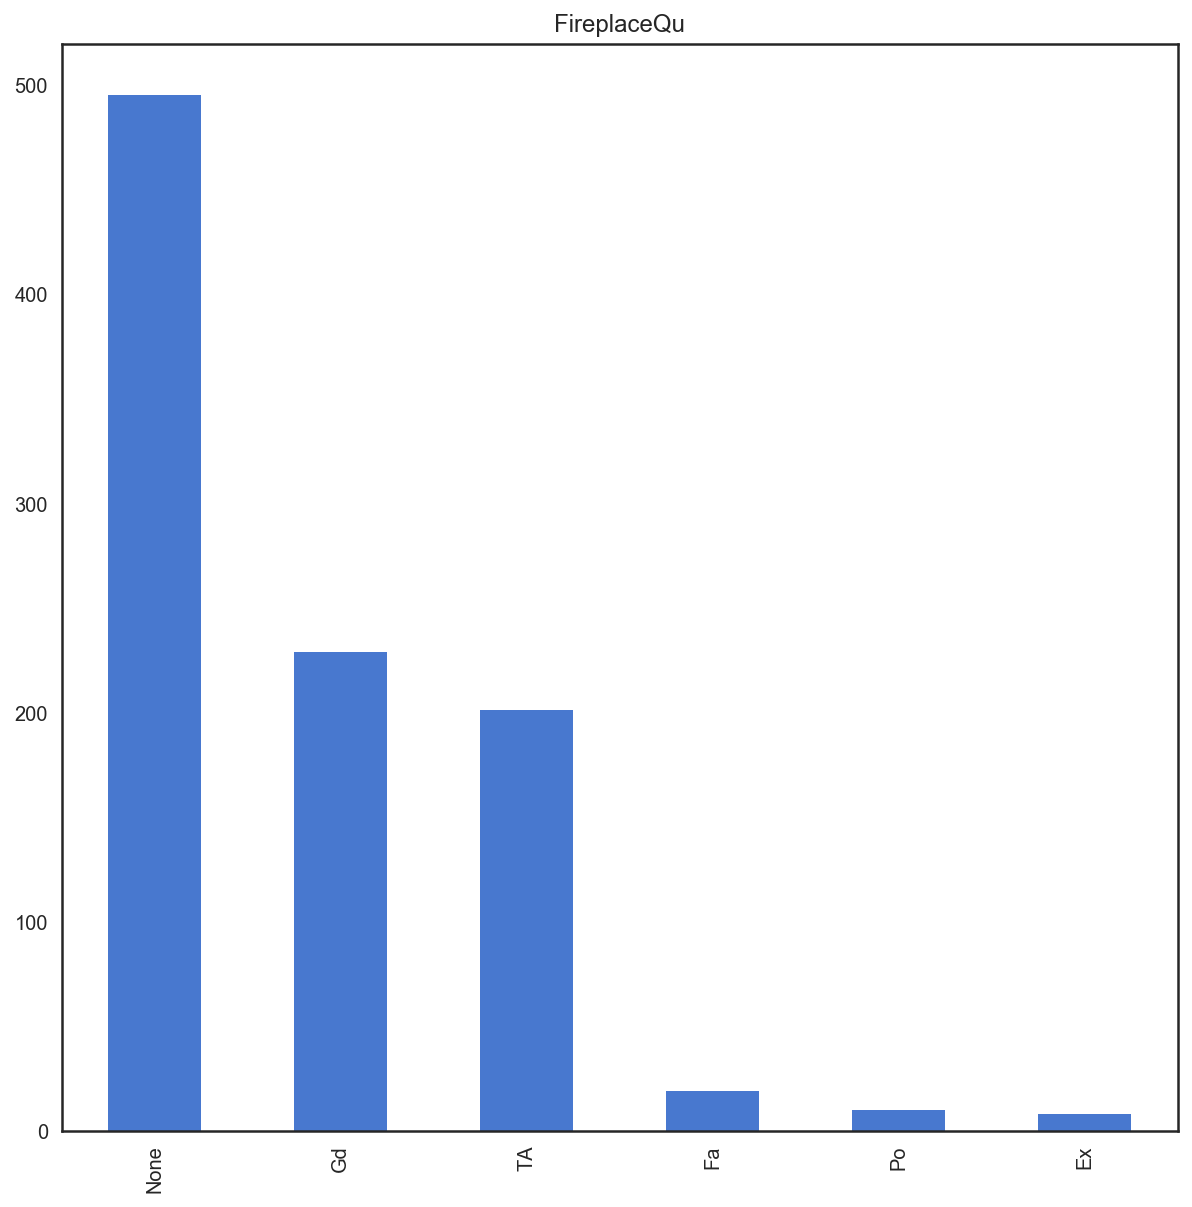

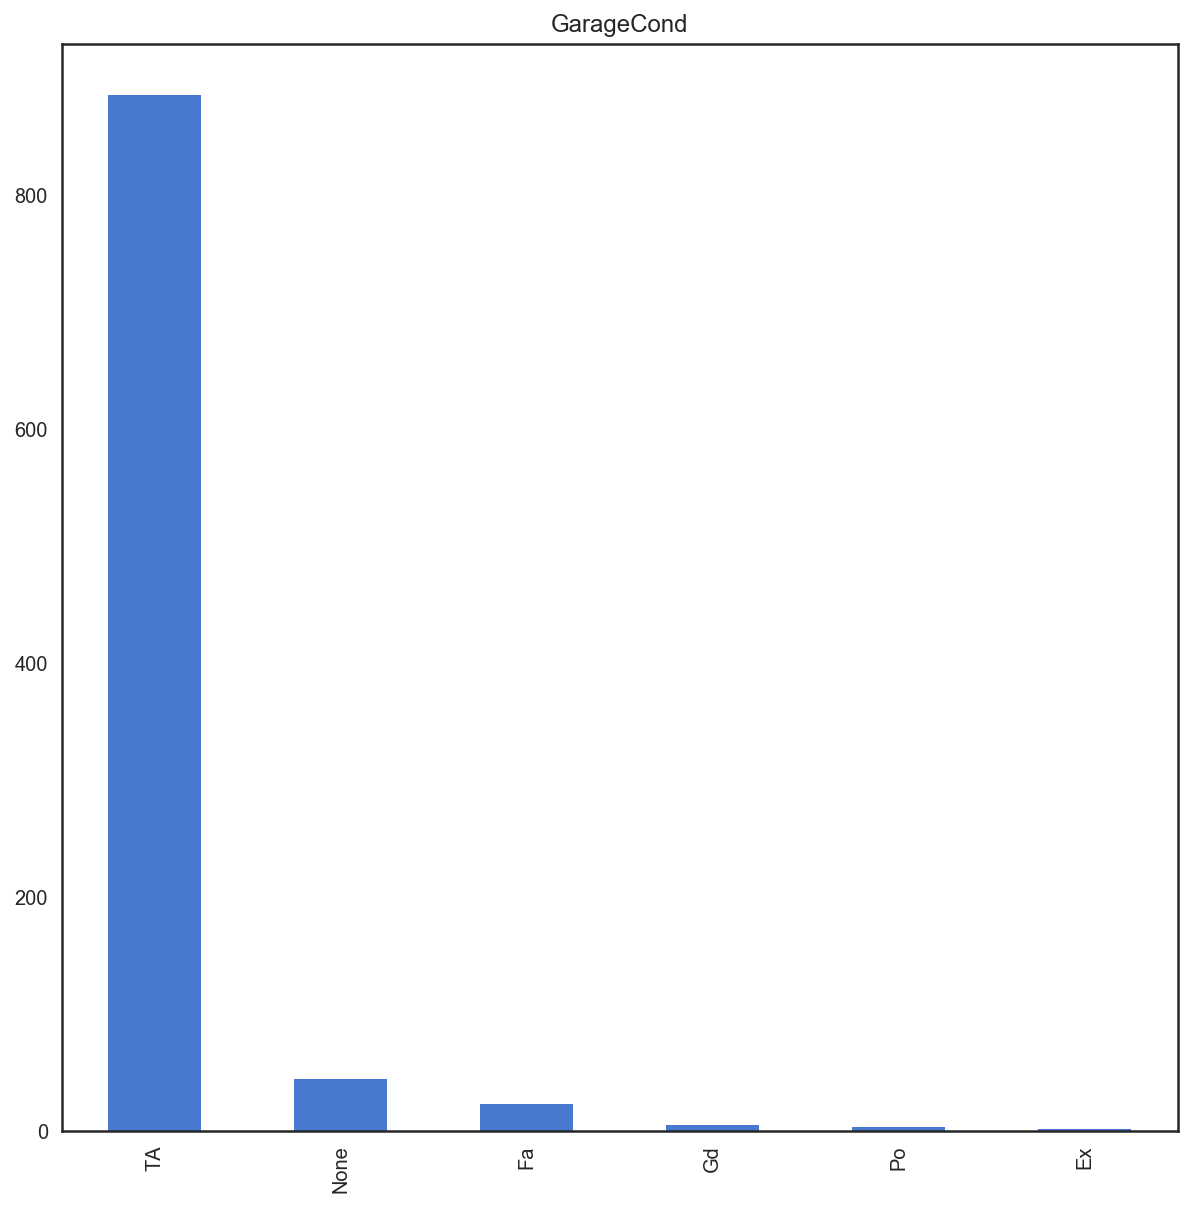

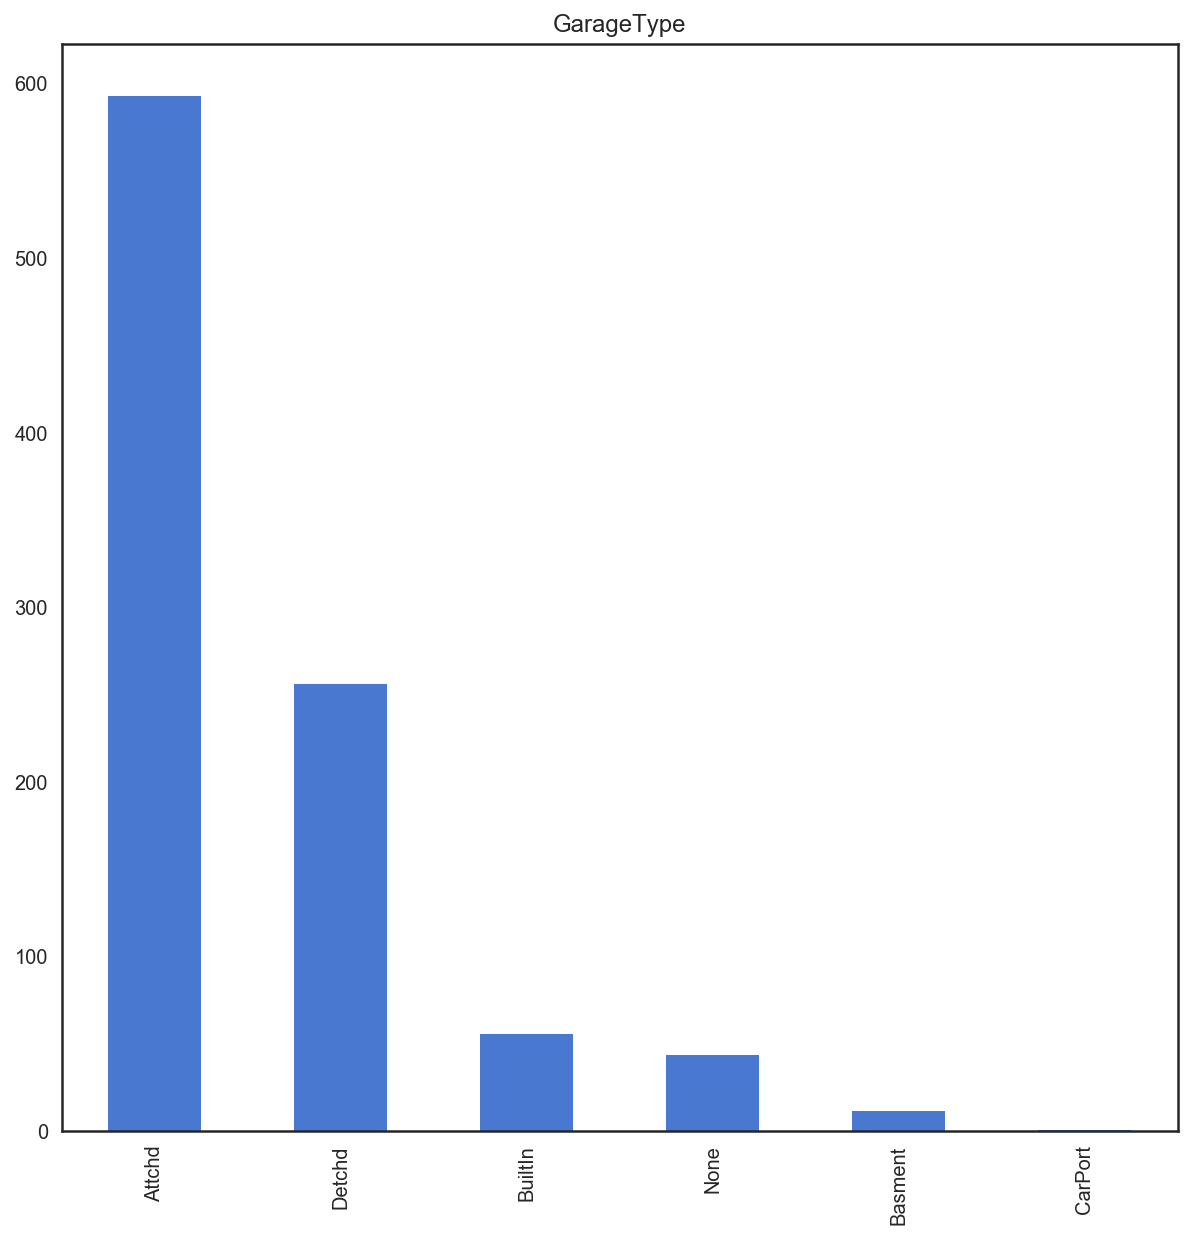

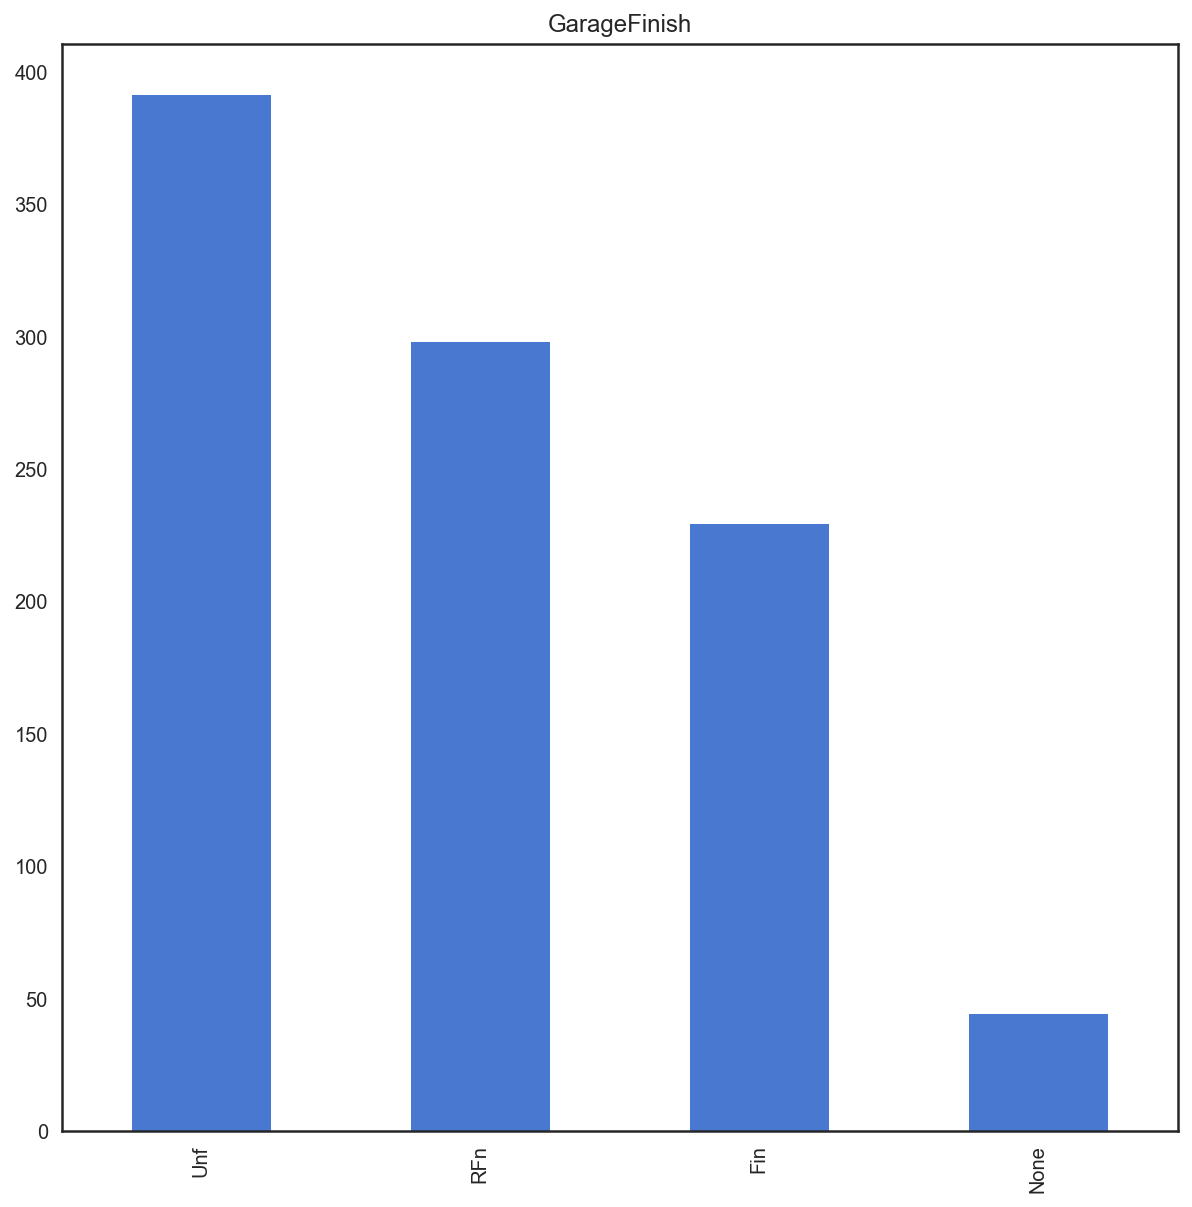

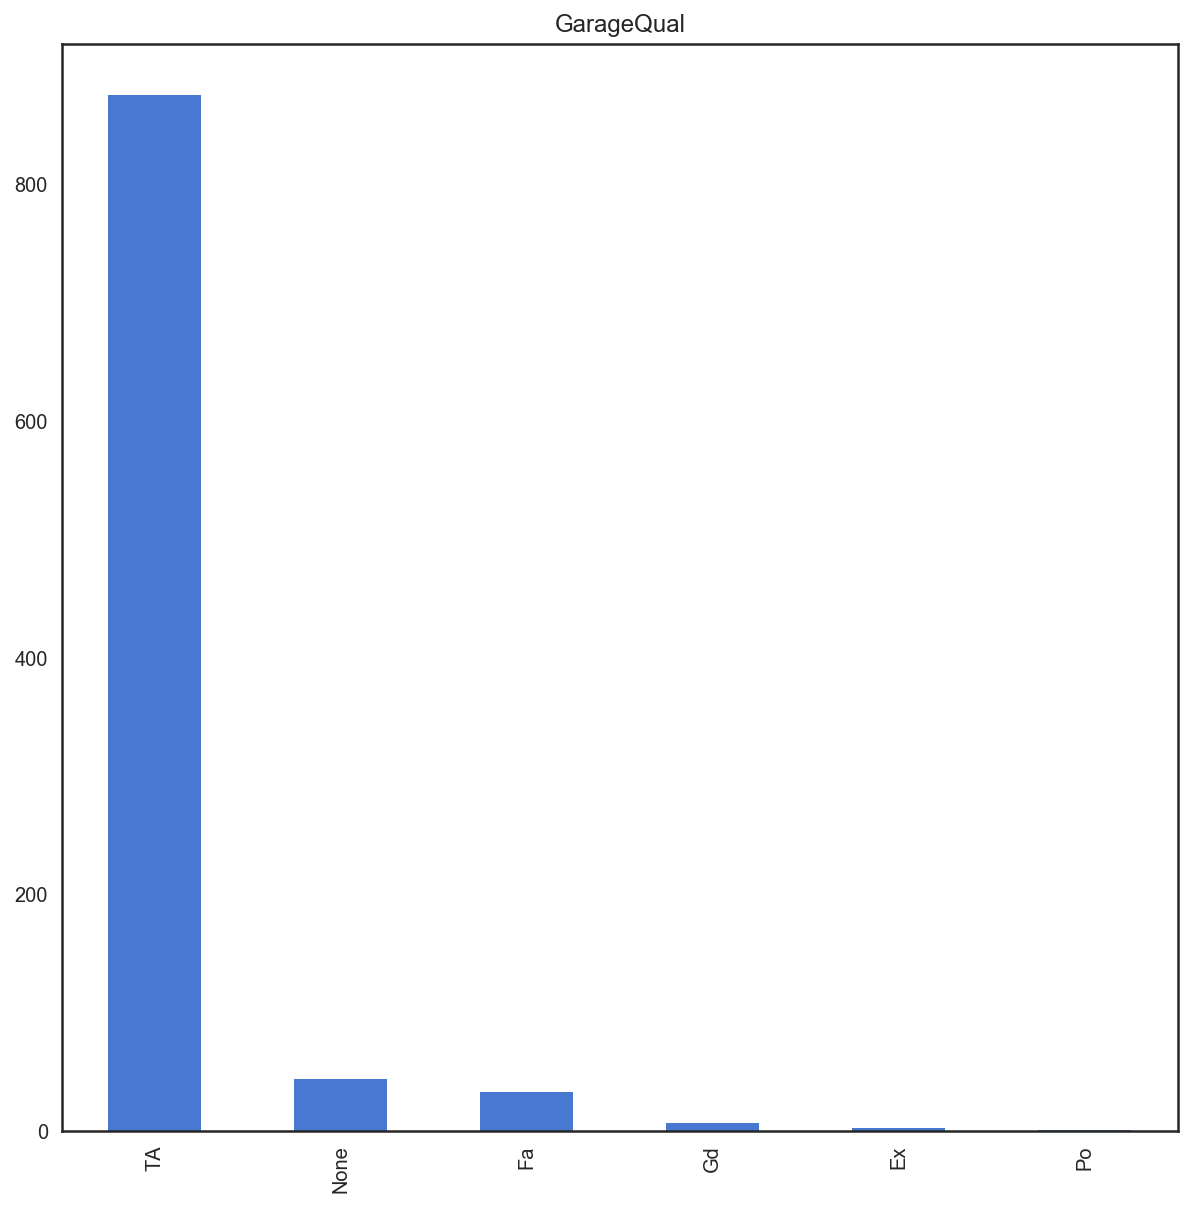

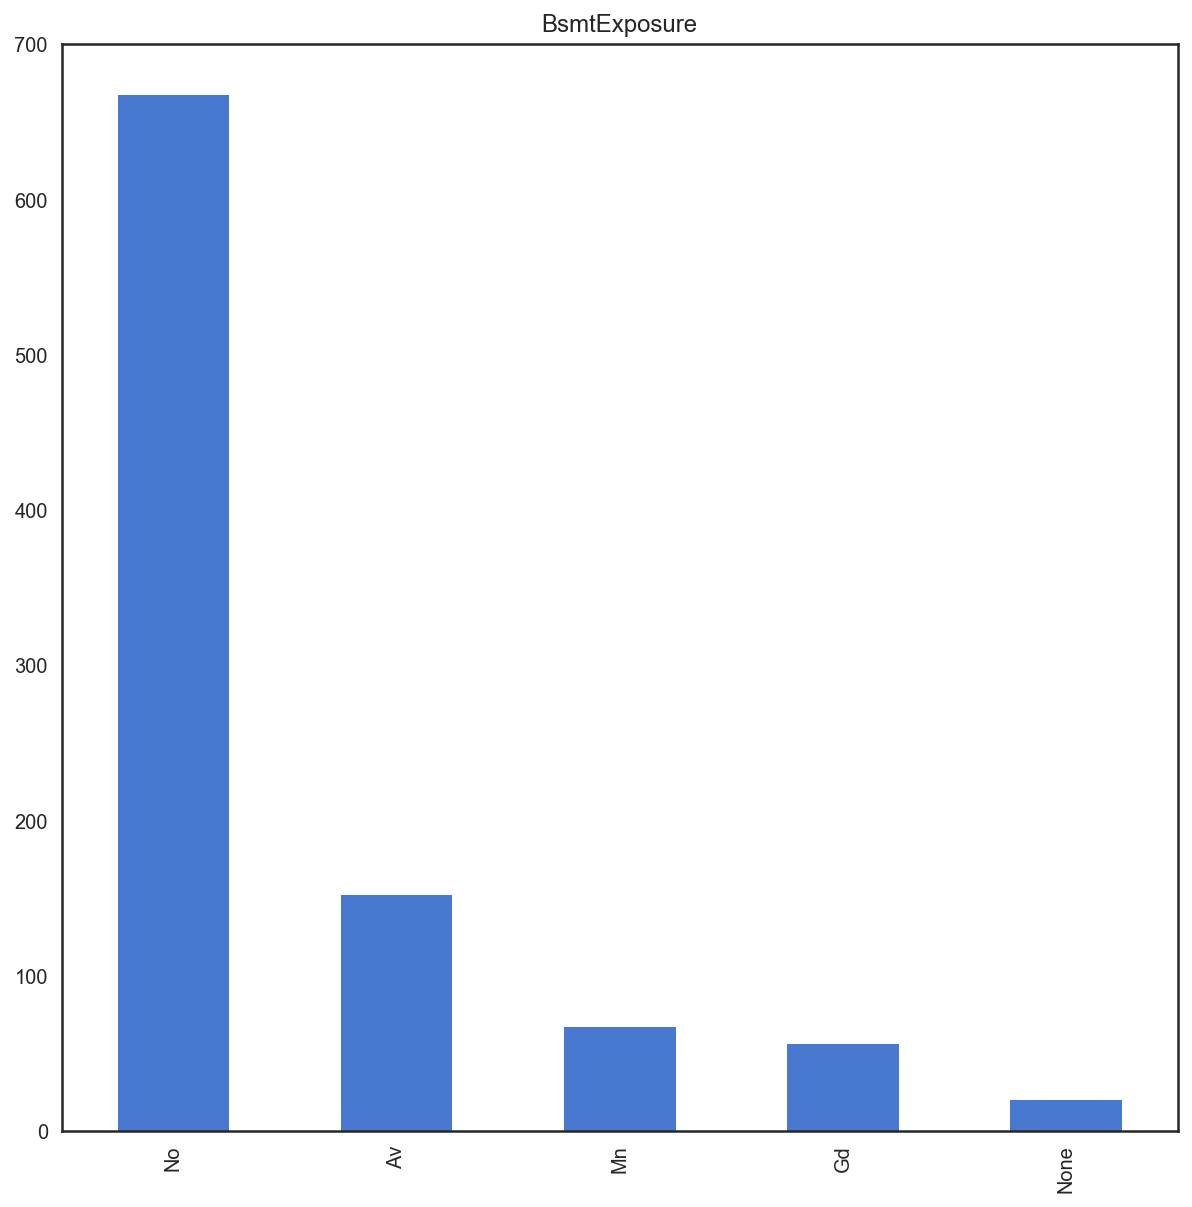

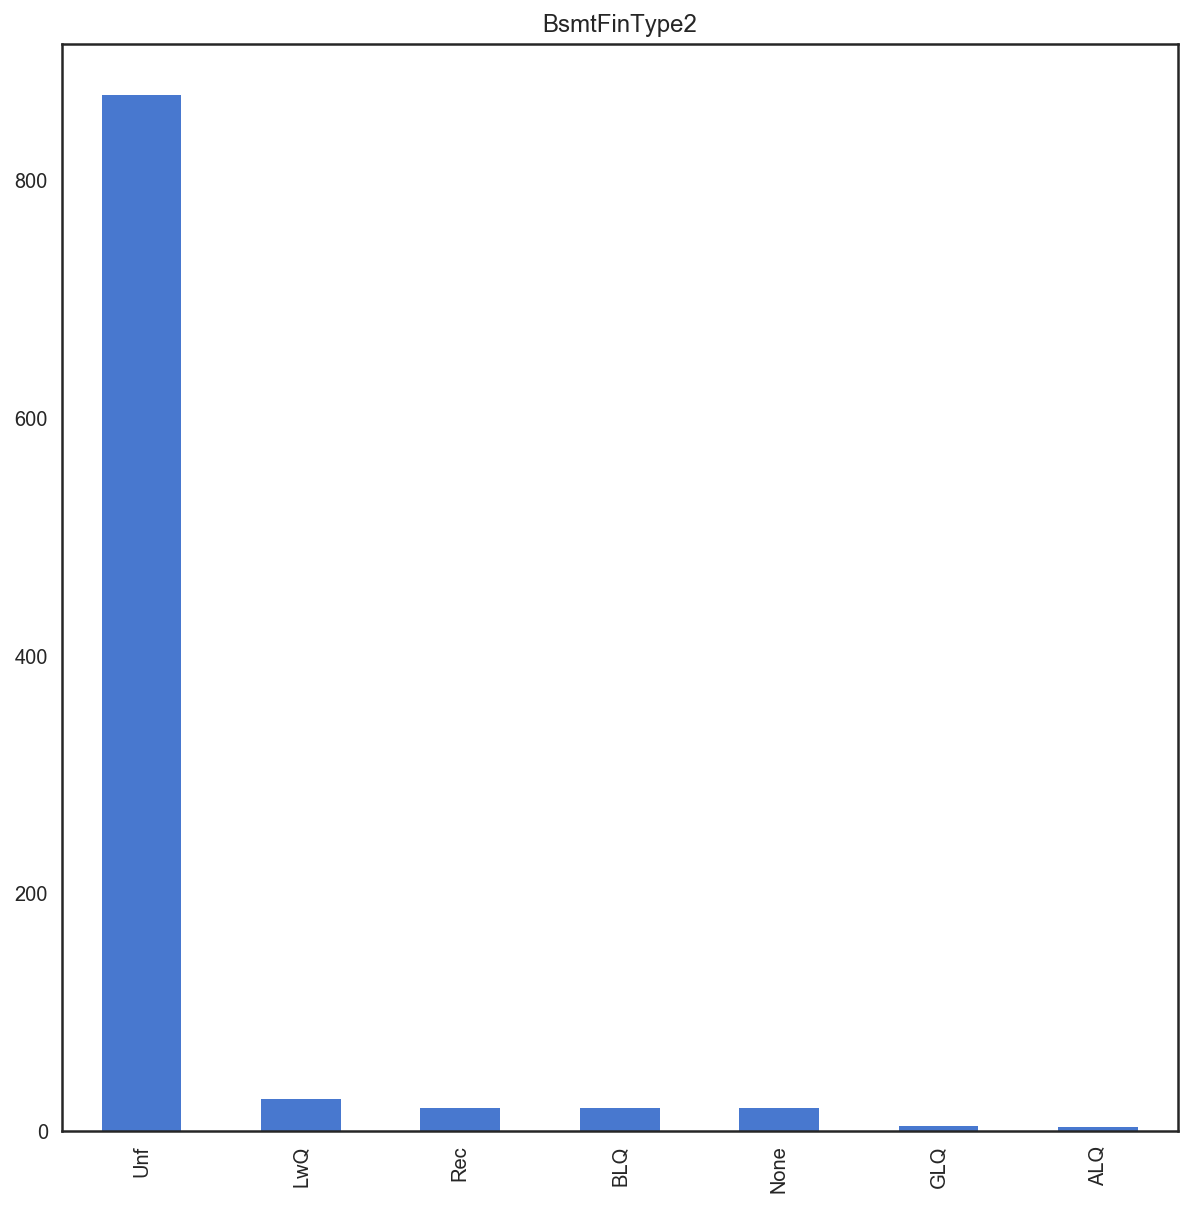

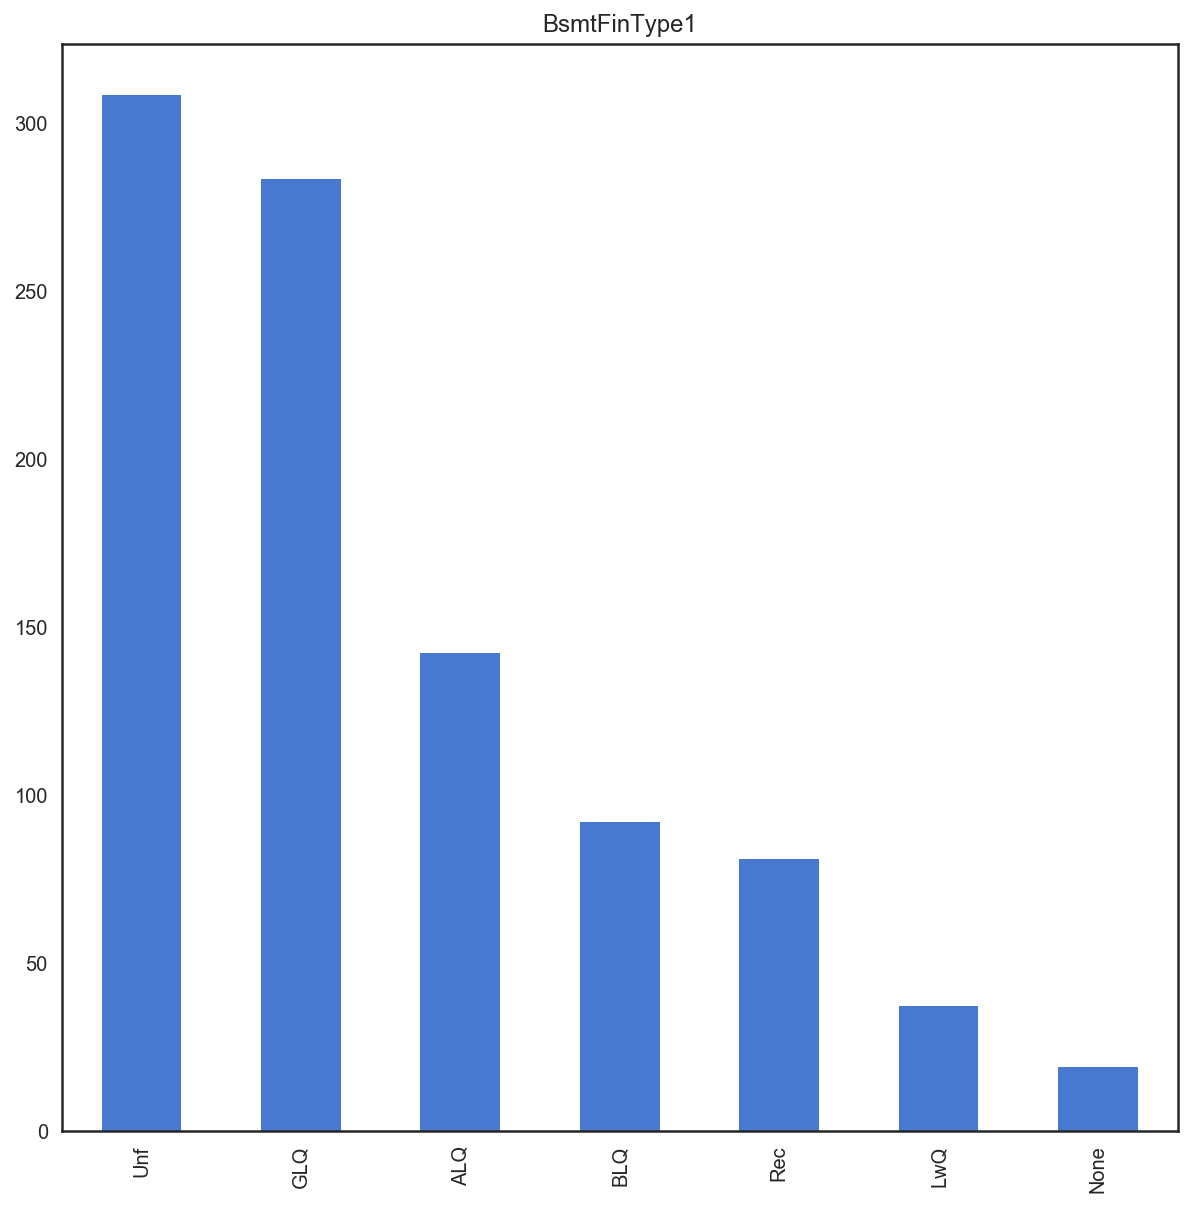

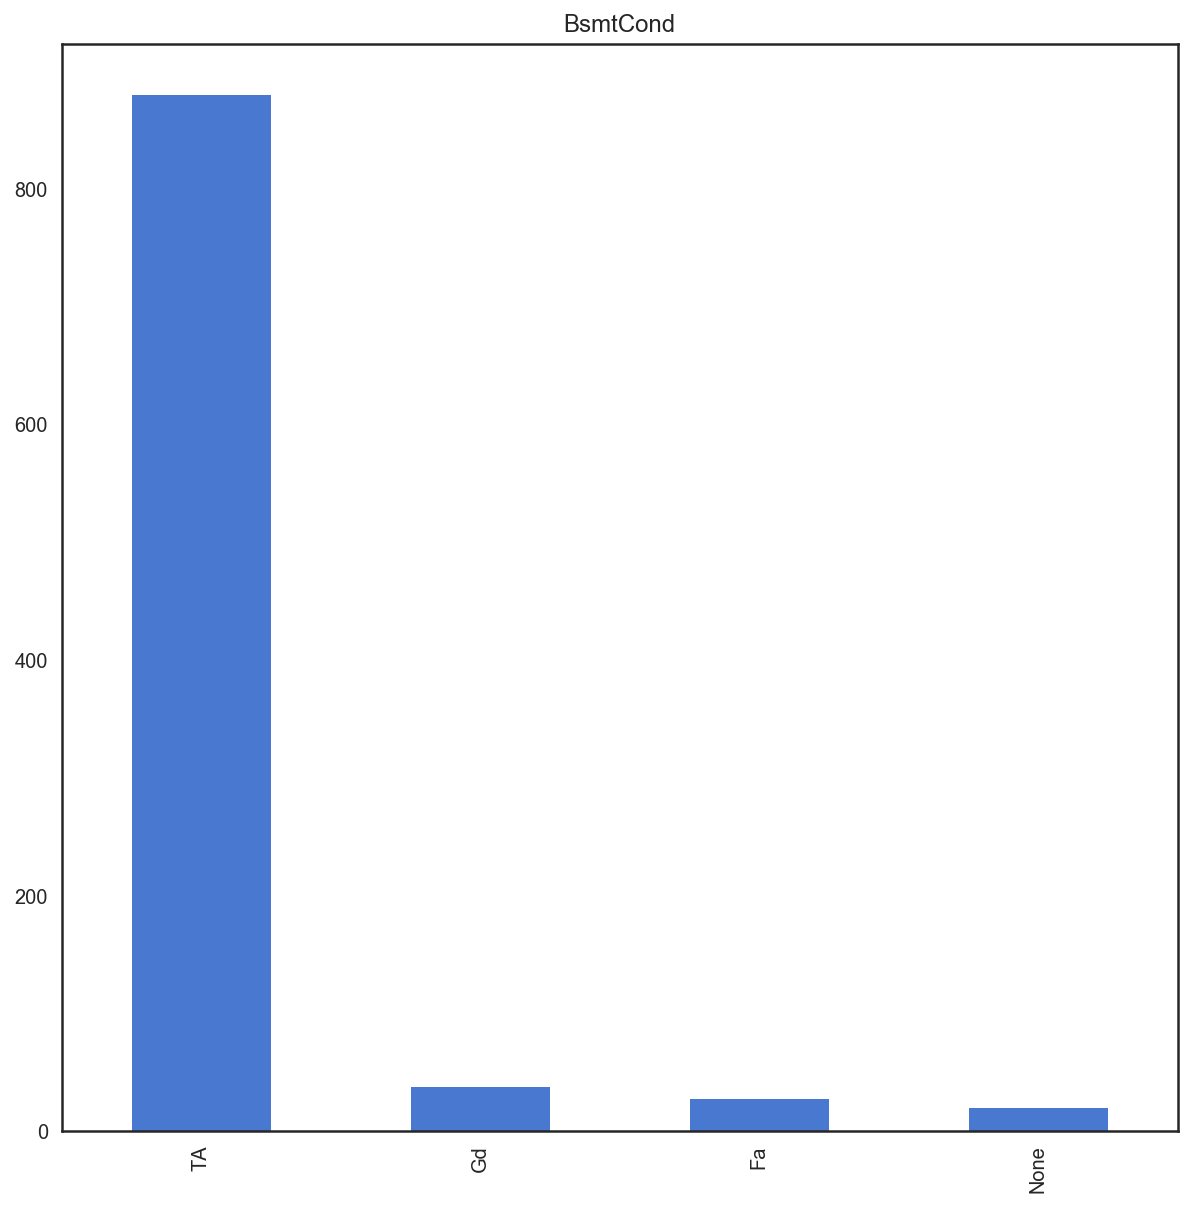

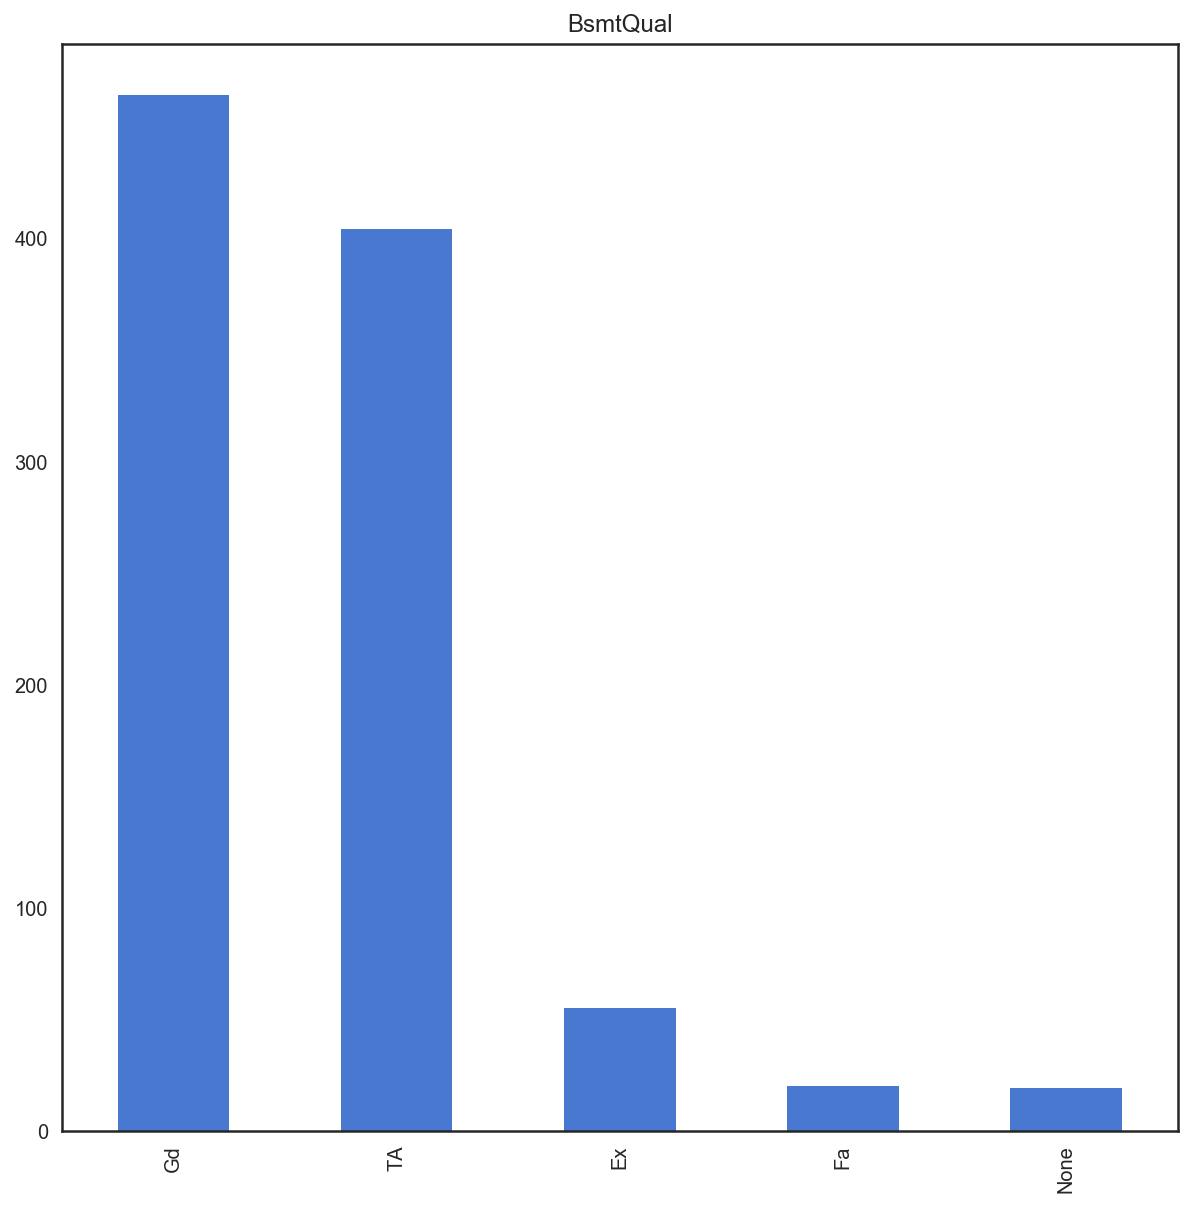

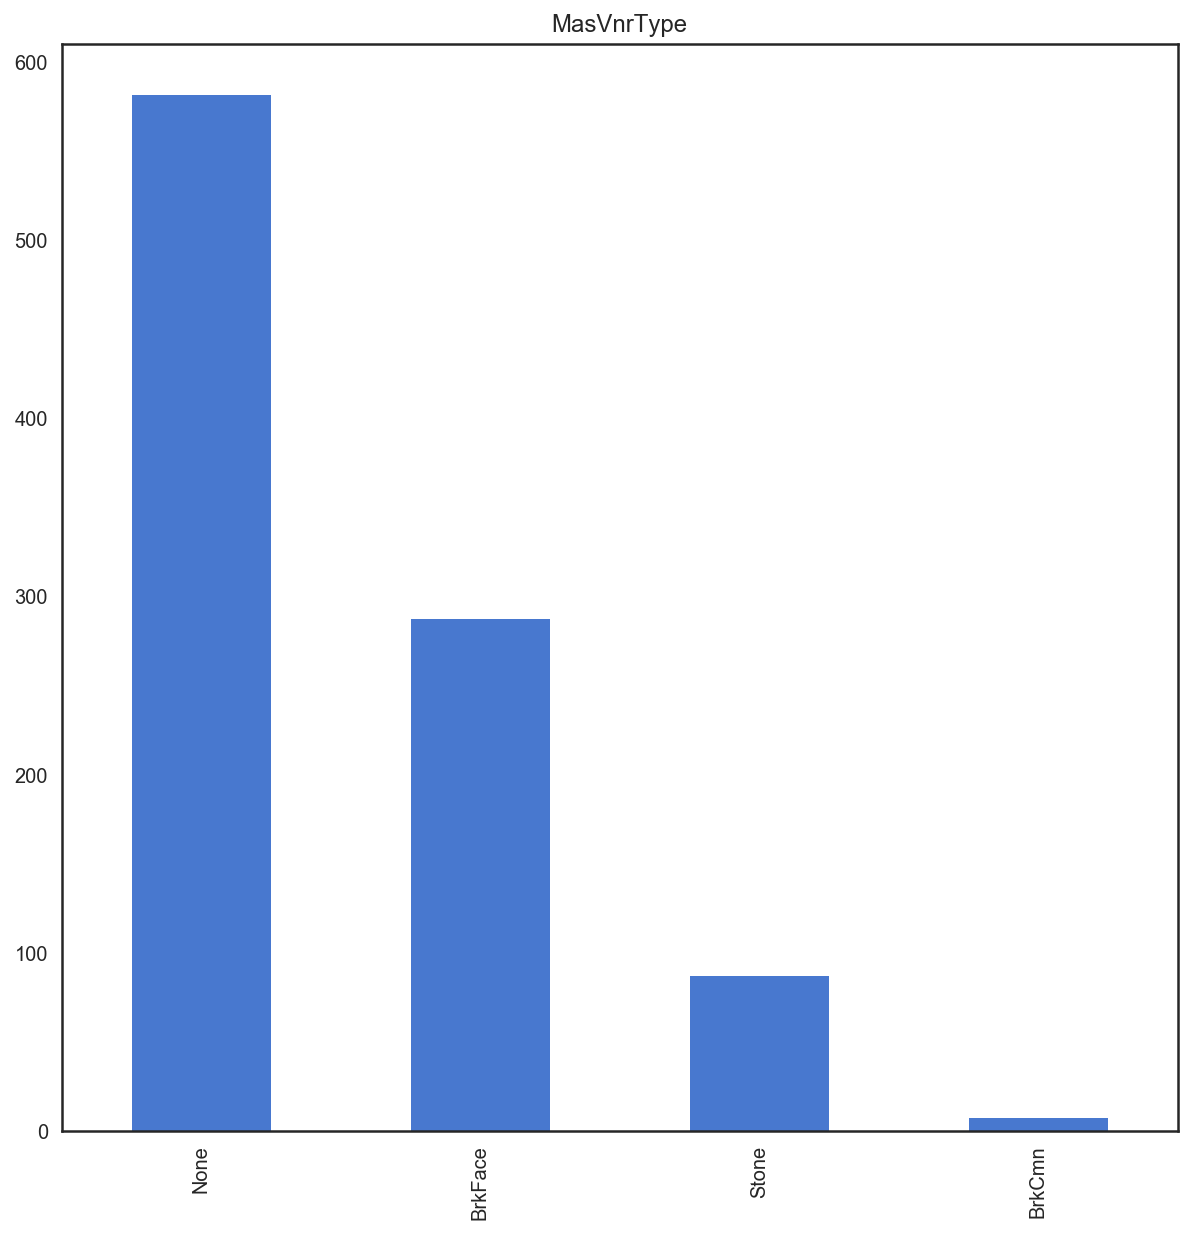

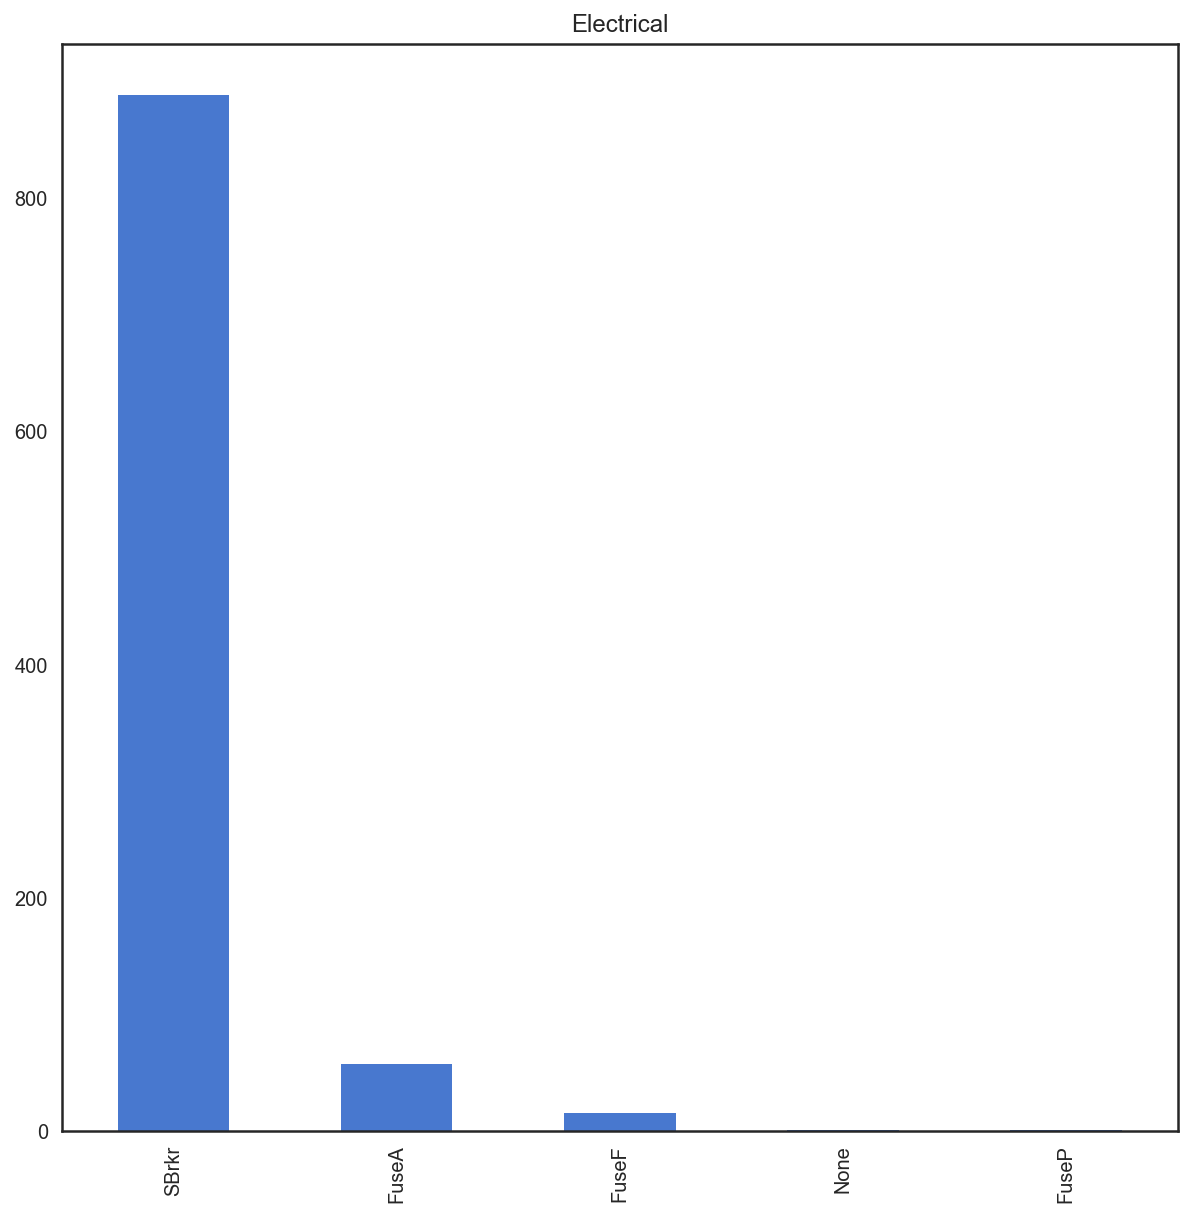

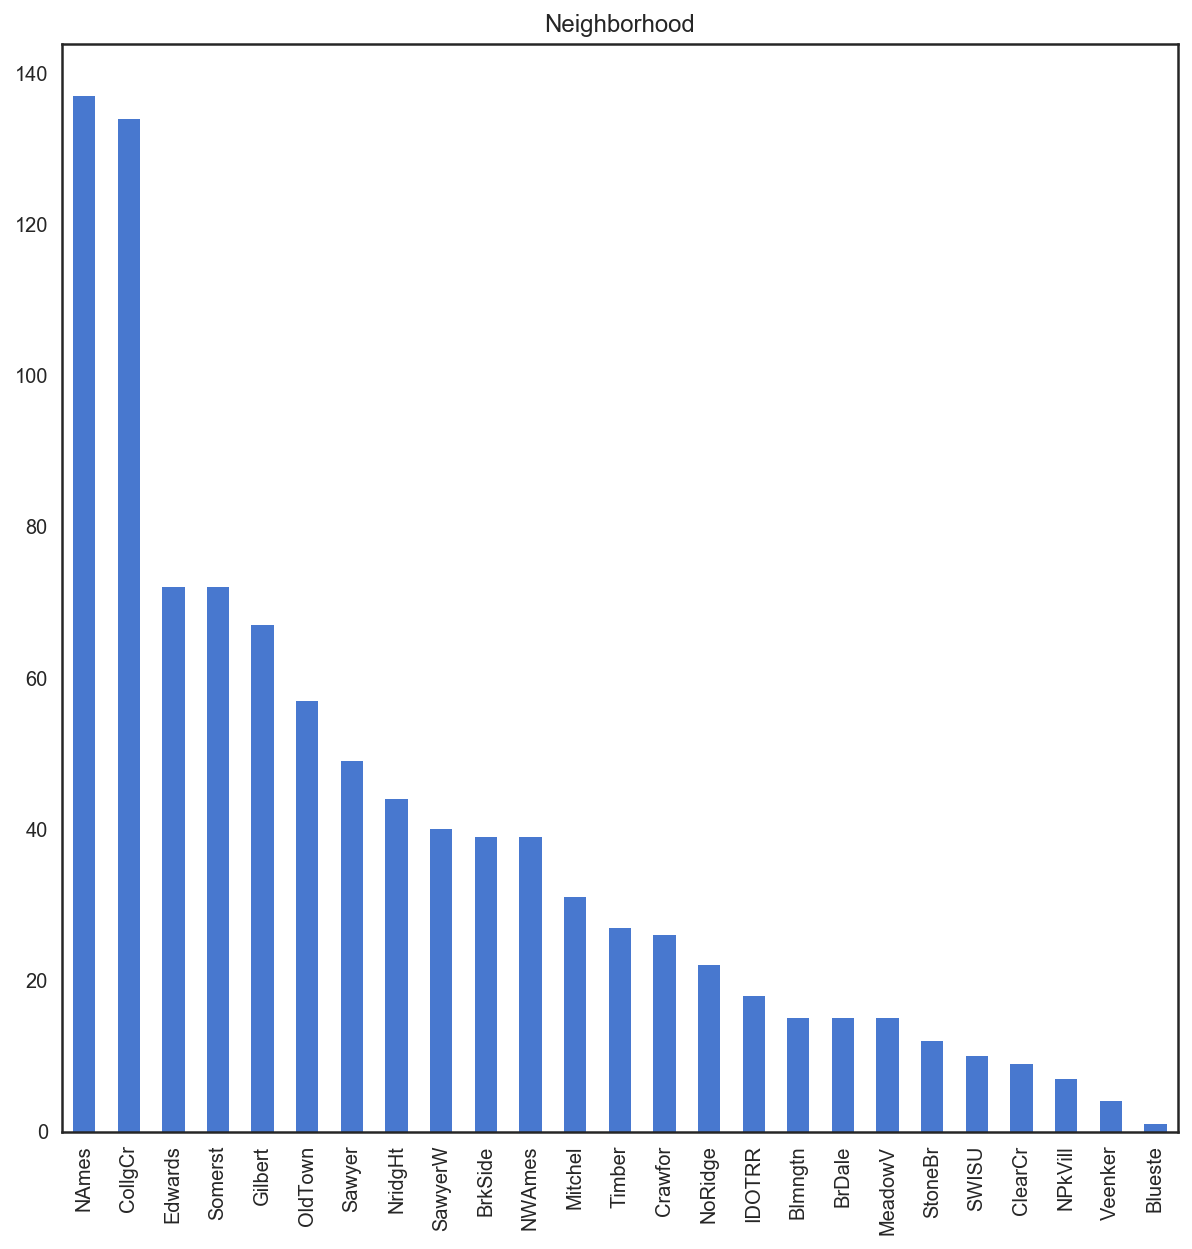

In [18]:
import seaborn as sns
for col in categorical_columns:
    sns.set(rc={"figure.figsize": (10, 10)})
    sns.set(color_codes=True)
    sns.set(style="white", palette="muted")
    #dist = sns.distplot(house[col].value_counts(), bins=10 ,hist_kws={'alpha':0.5}, kde=False)
    house[col].value_counts().plot(kind='bar').set_title(col)
    plt.show()


# Checking if the data has outliers


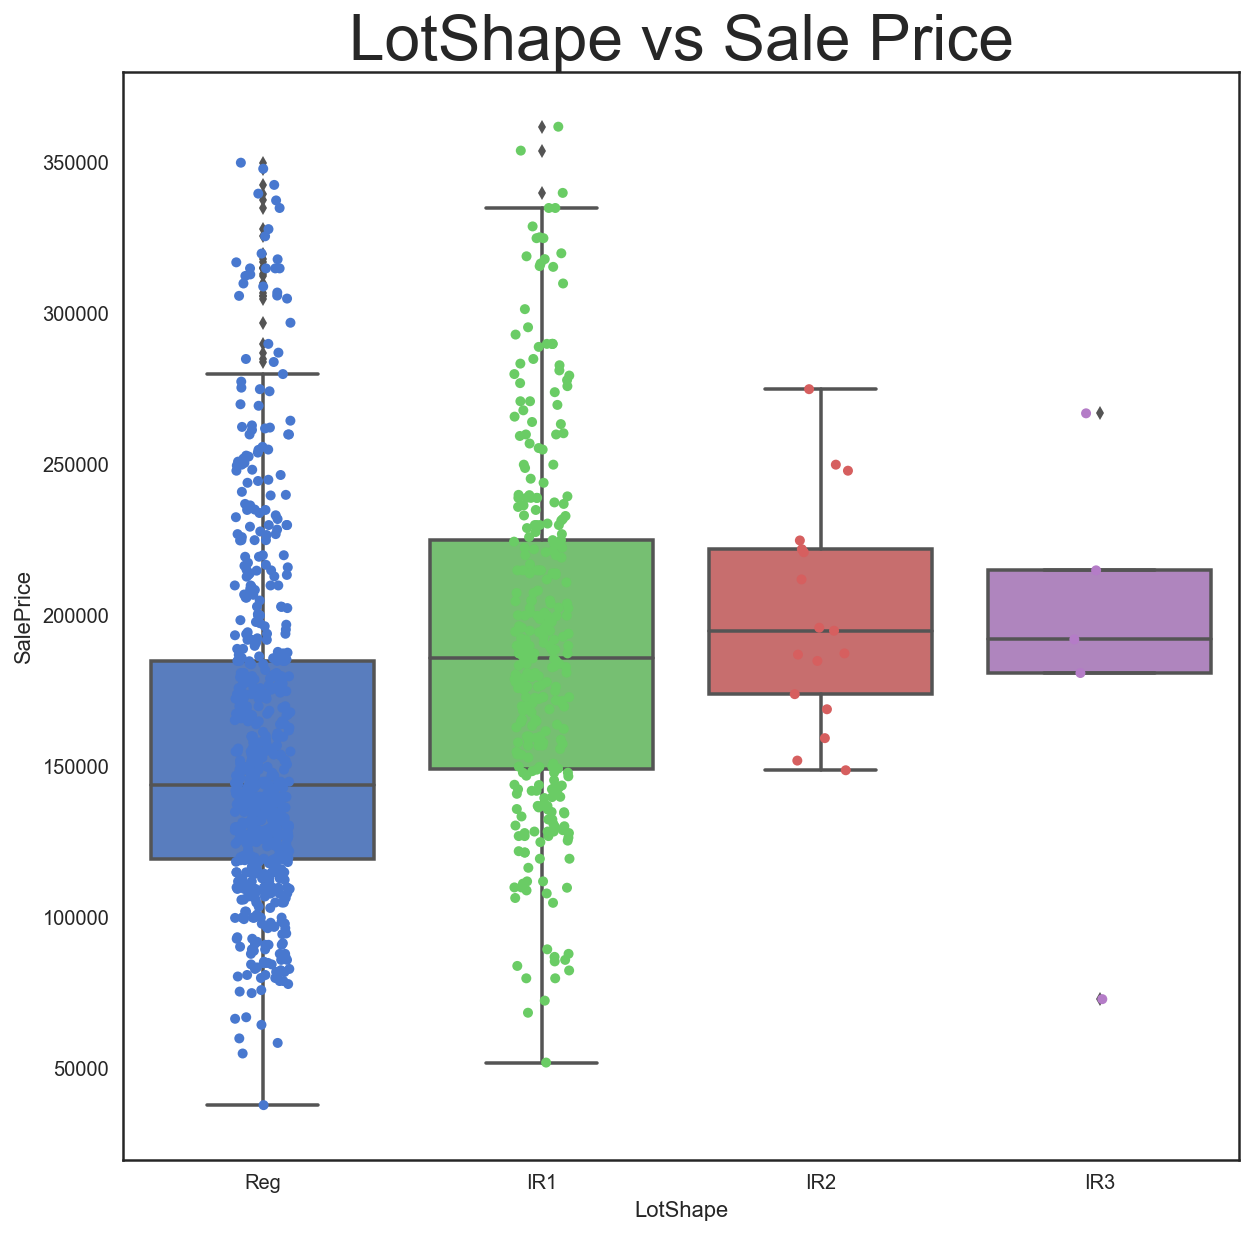

In [19]:
#Plot the boxplots of lotShape against Sale Price
ax = sns.boxplot(x="LotShape", y="SalePrice", 
                data=house)
ax = sns.stripplot(x="LotShape", y="SalePrice",
                   data=house, jitter=True,
                   edgecolor="gray")
plt.title("LotShape vs Sale Price",fontsize=32);

Text(0.5,1,u'MSZoning vs Sale Price')

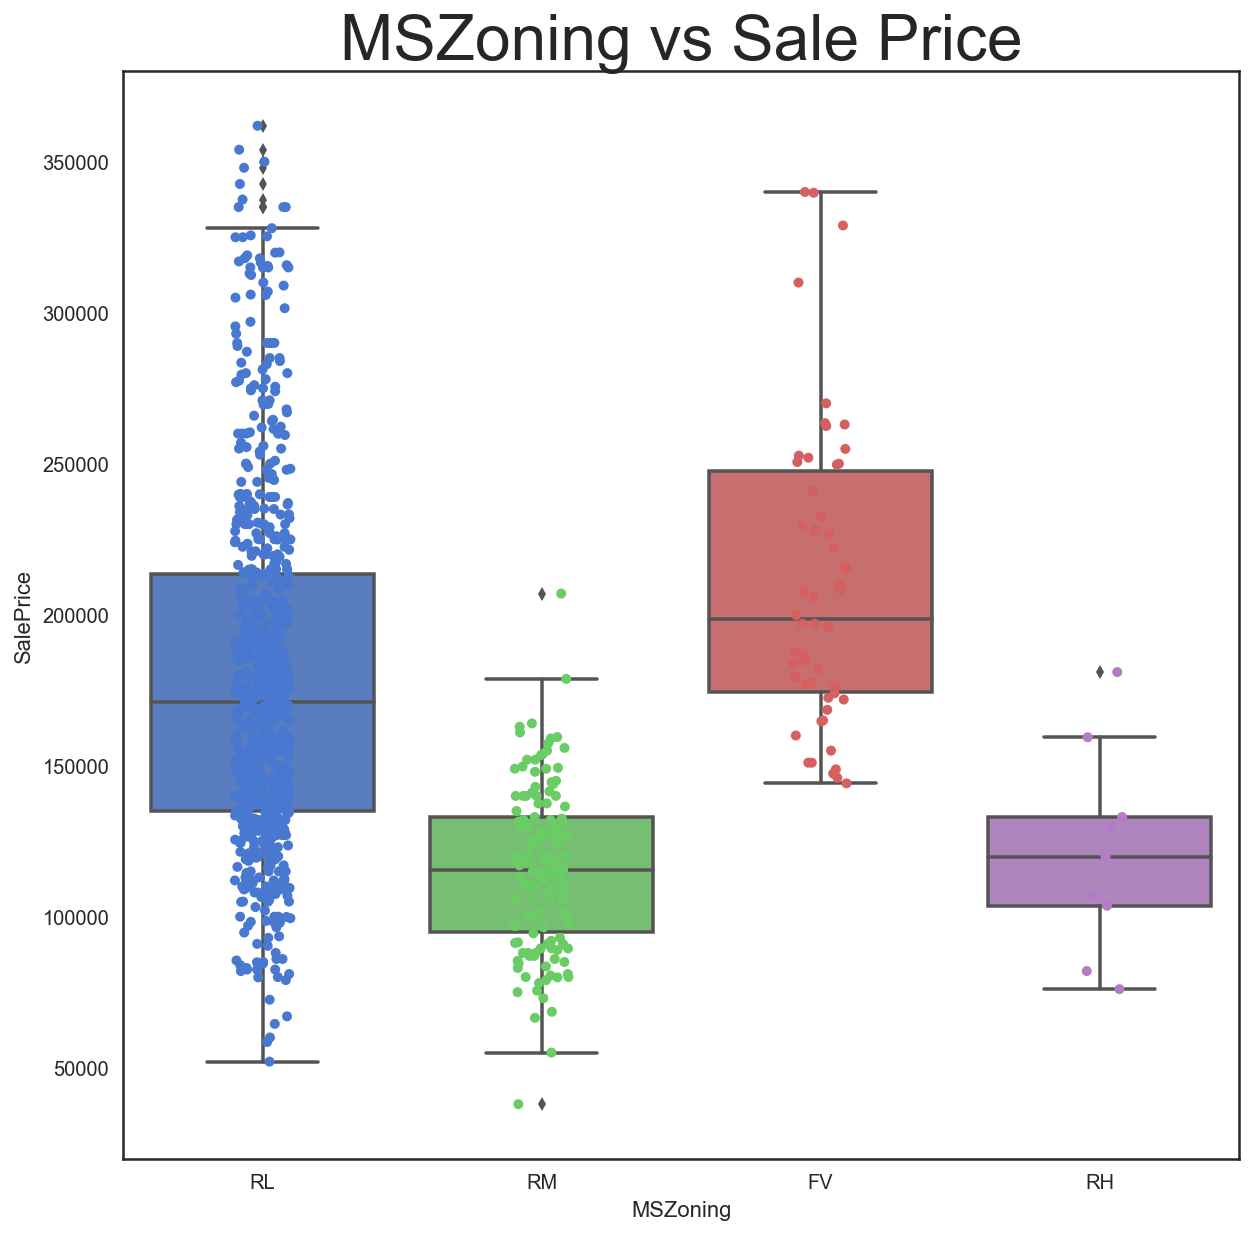

In [20]:
#Plot the boxplots of MsZoning against Sale Price
ax = sns.boxplot(x="MSZoning", y="SalePrice", 
                data=house)
ax = sns.stripplot(x="MSZoning", y="SalePrice",
                   data=house, jitter=True,
                   edgecolor="gray")
plt.title("MSZoning vs Sale Price",fontsize=32)

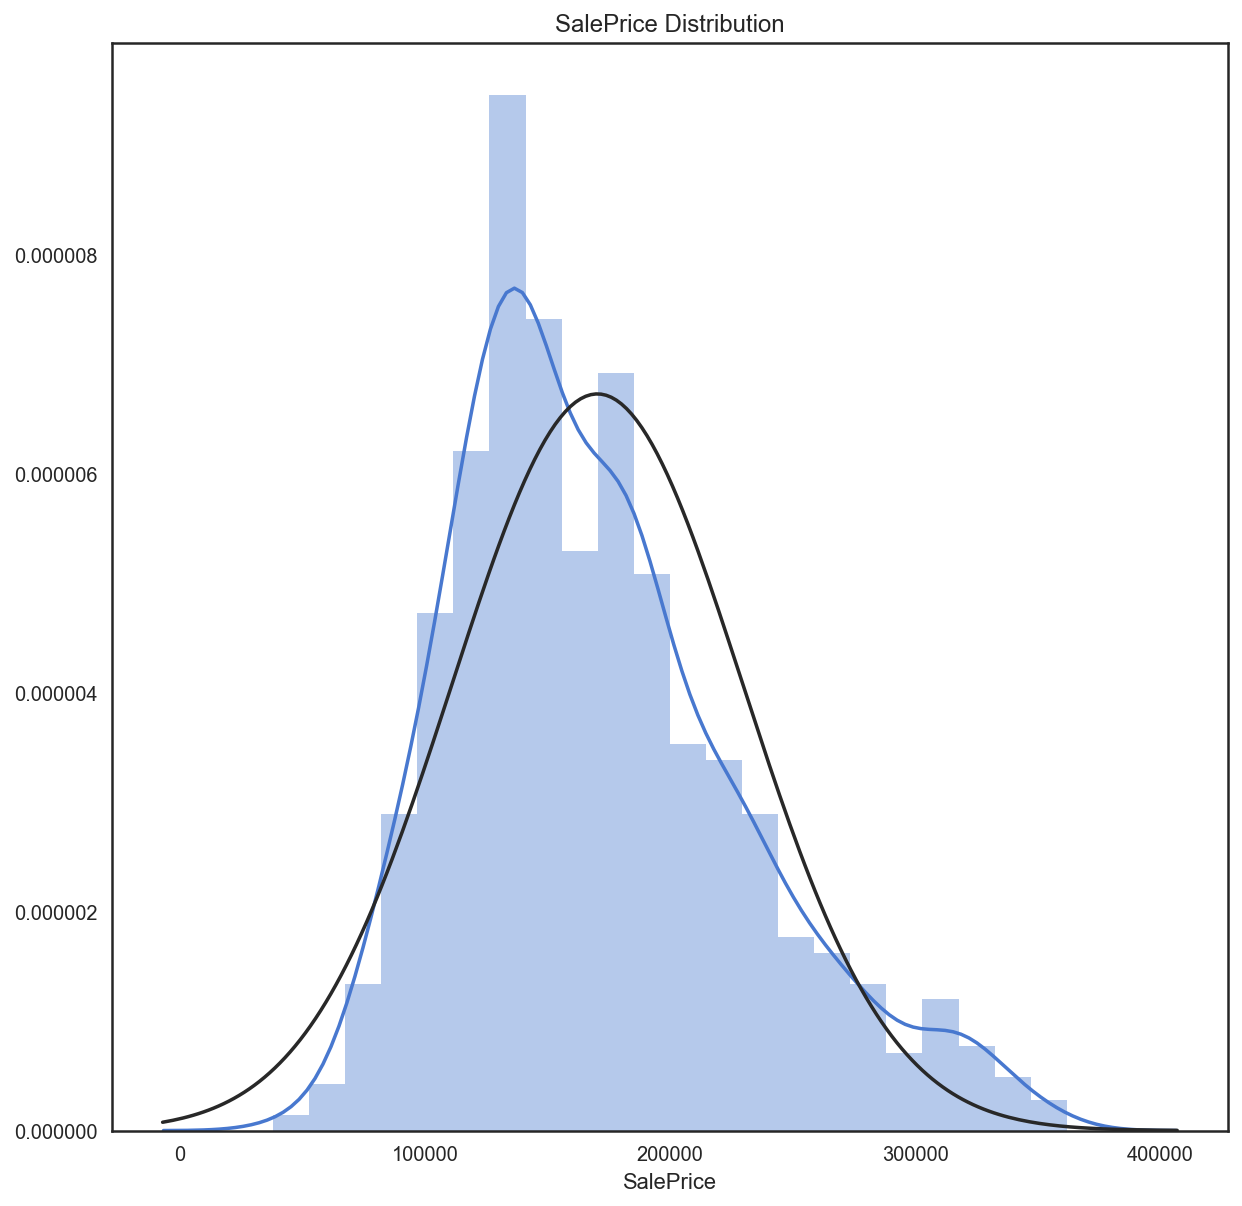

In [21]:
#Plots the Sale price distribution
from scipy.stats import norm
sns.distplot(house['SalePrice'], fit=norm).set_title('SalePrice Distribution')
fig = plt.figure()


We can see that it's Positively skewed

In [22]:
house['SalePrice'].describe()

count       962.000000
mean     170308.391892
std       59317.974280
min       37900.000000
25%      128000.000000
50%      159217.000000
75%      202975.000000
max      361919.000000
Name: SalePrice, dtype: float64

This is what my first thought was to do but I couldn't make it real haha, using Knn Algorithm to fill the nan values of the "LotFrontage" column:
(The column LotFrontage has only 169 null values, instead of setting them with 0, I will get a predicted value 
using the Knn Algorithm. First of all, I will check the correlation between the variables to get the strongest one
to use it as a matrix to predict the value)

In [23]:
#Gets a hetmaps to check the correlation among the variables
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
# calculate the correlation matrix
corr = Numerical_df.corr()
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

/Users/noelialopez83/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [24]:
house['LotArea'].corr(house['LotFrontage'])

0.27524105351691075

I will use the"LotArea" values to get the predicted values I need.
Please see that is all in comments because I decided not to use it because I couldnt get with the right algorithm.

In [25]:
# #Knn Algorithm
# X_incomplete = house[["LotArea", "LotFrontage"]]
# import numpy as np
# import random
# from sklearn import datasets
# from sklearn import neighbors

# def impute(mat, learner, n_iter=3):
#     mat = np.array(mat)
#     mat_isnan = np.isnan(mat)        
#     w = np.where(np.isnan(mat))
#     ximp = mat.copy()
#     for i in range(0, len(w[0])):
#         n = w[0][i] # row where the nan is
#         p = w[1][i] # column where the nan is
#         col_isnan = mat_isnan[n, :] # empty columns in row n
#         train = np.delete(mat, n, axis = 0) # remove row n to obtain a training set
#         train_nonan = train[~np.apply_along_axis(np.any, 1, np.isnan(train)), :] # remove rows where there is a nan in the training set
#         target = train_nonan[:, p] # vector to be predicted
#         feature = train_nonan[:, ~col_isnan] # matrix of predictors
#         learn = learner.fit(feature, target) # learner
#         ximp[n, p] = learn.predict(mat[n, ~col_isnan].reshape(1, -1)) # predict and replace
#     for iter in range(0, n_iter):
#         for i in random.sample(range(0, len(w[0])), len(w[0])):
#             n = w[0][i] # row where the nan is
#             p = w[1][i] # column where the nan is
#             train = np.delete(ximp, n, axis = 0) # remove row n to obtain a training set
#             target = train[:, p] # vector to be predicted
#             feature = np.delete(train, p, axis=1) # matrix of predictors
#             learn = learner.fit(feature, target) # learner
#             ximp[n, p] = learn.predict(np.delete(ximp[n,:], p).reshape(1, -1)) # predict and replace
    
#     return ximp



# a= impute(mat=X_incomplete, learner=neighbors.KNeighborsRegressor(n_neighbors=3), n_iter=10)
# b=pd.DataFrame(a, columns=["LotAreaFixed", "LotFrontageFixed"])

In [26]:
# #Shows the original data against the one we already fixed
# new_df = pd.concat([house[["LotArea", "LotFrontage"]],b], axis=1, ignore_index=True)
# new_df.columns = ["LotArea", "LotFrontage","LotAreaFixed", "LotFrontageFixed"]
# new_df.head(8)
# #new_df.to_clipboard()

In [27]:
# house["LotFrontage"] = b["LotFrontageFixed"]
# print house.LotFrontage.shape
# print b.LotFrontageFixed.shape
# print house.LotFrontage.isnull().sum()
# house.head(8)
# b.to_clipboard()

In [28]:
# from pandas import ExcelWriter
# writer = ExcelWriter('house.xlsx')
# house.to_excel(writer,'Sheet1')
# writer.save()


In [29]:
#Gets the columns with null values
nulls = house.isnull().sum()
nulls.sort_values(ascending=False).head(5)

SalePrice      0
Heating        0
Exterior1st    0
Exterior2nd    0
MasVnrType     0
dtype: int64

In [30]:
#Function that gets the dummie variables and drop the categorical variables
def get_dummies(df):
    columns= []
    dummies = pd.DataFrame()
    for n in df.columns:
        if df[n].dtype == 'object':
            columns.append(n)
            dumm=pd.get_dummies(df[n], prefix=n, drop_first=True)
            dummies = pd.concat([dummies,dumm], axis=1, ignore_index=False)
    df = pd.concat([df,dummies], axis=1, ignore_index=False)
    df.drop(columns,axis=1, inplace=True)
    return df


# 3. Identifying fixed features that can predict price

In [31]:
# Load the data with just the fixed variables
fixed_columns= ['SalePrice','Neighborhood','YearBuilt','1stFlrSF','2ndFlrSF', 'PoolArea', 'LotConfig', 
                'LotArea','MasVnrArea','MasVnrType', 'LandSlope', 'GarageCars','LowQualFinSF', 'BedroomAbvGr', 
                'LotShape','LandContour','Foundation', 'TotRmsAbvGrd','BsmtExposure', 'BsmtFinSF1','TotalBsmtSF',
                'Exterior1st','Exterior2nd', 'GrLivArea', 'KitchenAbvGr', 'LotFrontage', 'OverallQual','YrSold']
print len(fixed_columns)
fixed_df=house[fixed_columns]
fixed_dummies_df=get_dummies(fixed_df)
fixed_dummies_df.head()

28


,SalePrice,YearBuilt,1stFlrSF,2ndFlrSF,PoolArea,LotArea,MasVnrArea,GarageCars,LowQualFinSF,BedroomAbvGr,TotRmsAbvGrd,BsmtFinSF1,TotalBsmtSF,GrLivArea,KitchenAbvGr,LotFrontage,OverallQual,YrSold,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,LandSlope_Mod,LandSlope_Sev,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng
0,208500,2003,856,854,0,8450,196.0,2,0,3,8,706,856,1710,1,65.0,7,2008,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,223500,2001,920,866,0,11250,162.0,2,0,3,6,486,920,1786,1,68.0,7,2008,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,250000,2000,1145,1053,0,14260,350.0,3,0,4,9,655,1145,2198,1,84.0,8,2008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,307000,2004,1694,0,0,10084,186.0,2,0,3,7,1369,1686,1694,1,75.0,8,2007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10,129500,1965,1040,0,0,11200,0.0,1,0,3,5,906,1040,1040,1,70.0,5,2008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [34]:
#Feature Selection
cols = list(fixed_dummies_df.columns)
cols.remove('SalePrice')

before_2010 = fixed_dummies_df[fixed_dummies_df['YrSold']<2010]
after_2010 = fixed_dummies_df[fixed_dummies_df['YrSold']>=2010]
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X_train)

#Dividing into training and testing subsets
X_train = before_2010[cols]
X_test = after_2010[cols]
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)
y_train = before_2010['SalePrice']
y_test = after_2010['SalePrice']

# K-Best for Feature Selection

Let's use the SelectKBest method in scikit learn to see which are the top 12 features. Also load the f_classif and chi2 functions which will be our metrics to evaluate what makes a variable the "best".

In [35]:
from sklearn.feature_selection import SelectKBest,f_regression, chi2

# build the selector (we'll build one with each score type)
skb_f = SelectKBest(f_regression, k=12)
skb_chi2 = SelectKBest(chi2, k=12)
# train the selector on our data
skb_f.fit(X_train, y_train)
skb_chi2.fit(X_train, y_train)

# examine results
kbest = pd.DataFrame([list(X_train), list(skb_f.scores_), list(skb_chi2.scores_)], 
                     index=['feature','f_regression', 'chi2 score']).T.sort_values('f_regression', ascending=False)
kbest_columns = kbest.feature.values[0:20]
kbest

/Users/noelialopez83/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in divide
  corr /= X_norms
/Users/noelialopez83/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms
/Users/noelialopez83/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/noelialopez83/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/noelialopez83/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/noelialopez83/anaconda2/

,feature,f_regression,chi2 score
15,OverallQual,1602.65,191.094
12,GrLivArea,1205.96,84194.2
6,GarageCars,824.388,180.074
0,YearBuilt,567.167,266.27
9,TotRmsAbvGrd,468.388,180.796
11,TotalBsmtSF,465.347,74664.4
57,Foundation_PConc,415.037,280.221
1,1stFlrSF,386.134,52511
73,Exterior1st_VinylSd,205.144,331.662
86,Exterior2nd_VinylSd,196.728,333.757


The f-test is explained variance divided by unexplained variance. High numbers will results if our explained variance, what we know is much greater than unexplained, what we dont know. A high value of chi^2 indicates that the hypothesis of independence is incorrect. In other words, the higher value of the chi^2 score, the more likelihood the feature is correlated with the class, thus it should be selected for model training.

# Recursive Feature Elimination (RFE) for feature selection

When instantiating the RFECV:

step indicates what percent of features (or number of features if an integer) to remove at each iteration.
cv indicates the number of cross-validation folds to use for evaluating what features are important.


In [36]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X_train, y_train)

print selector.support_
print selector.ranking_

[ True  True  True False  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
[1 1 1 2 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [37]:
rfecv = pd.DataFrame([list(X_train), list(selector.support_),list(selector.ranking_) ], 
                     index=['feature','RFECV_support','RFECV_ranking']).T.sort_values('RFECV_ranking', ascending=True)
rfecv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 0 to 13
Data columns (total 3 columns):
feature          89 non-null object
RFECV_support    89 non-null object
RFECV_ranking    89 non-null object
dtypes: object(3)
memory usage: 2.8+ KB


In [38]:
rfecv_columns = rfecv[rfecv['RFECV_support'] == True]['feature']
rfecv_columns = list(rfecv_columns)
print len(rfecv_columns)

87


In [39]:
X_train.shape

(843, 89)

Recursive Feature Elimination (RFE) doesn't remove any of the columns

# Feature elimination using the lasso penalty

As the regularization strength increases more features will be removed

In [40]:
from sklearn.linear_model import RandomizedLasso

names = X_train.columns
rlasso = RandomizedLasso(alpha=0.025)
rlasso.fit(X_train, y_train)
 
print "Features sorted by their score:"
lasso = pd.DataFrame([list(X_train), list(rlasso.scores_)], 
                     index=['feature','R_Lasso_score']).T.sort_values('R_Lasso_score', ascending=False)
lasso

/Users/noelialopez83/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


Features sorted by their score:


,feature,R_Lasso_score
0,YearBuilt,1
27,Neighborhood_Mitchel,1
64,BsmtExposure_None,1
30,Neighborhood_NWAmes,1
31,Neighborhood_NoRidge,1
32,Neighborhood_NridgHt,1
33,Neighborhood_OldTown,1
34,Neighborhood_SWISU,1
35,Neighborhood_Sawyer,1
36,Neighborhood_SawyerW,1


In [41]:
lasso_columns = lasso.feature[lasso.R_Lasso_score != 0]
len(lasso_columns)

87

In [42]:
print('Percent variables zeroed out:', np.sum((lasso.R_Lasso_score == 0))/float(X_train.shape[0]))

('Percent variables zeroed out:', 0.0023724792408066431)


A few variables were eliminated, more than the RFE.

# Comparing the features sets

In [46]:
lr = LinearRegression()

# defining a function to test our best features head-to-head
def score(X_train):
    scores = cross_val_score(lr, X_train, y_train, cv=5)
    return scores.mean(), scores.std()

# list of all our lists of best features being executed in the score function
all_scores = [
    score(X_train[kbest_columns]),
    score(X_train[rfecv_columns]),
    score(X_train[lasso_columns]),
    ]
  
#putting results into a dataframe
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['kbest', 'rfecv', 'Randomized Lasso'])

,mean score,std score
kbest,0.878287,0.017672
rfecv,0.885174,0.020112
Randomized Lasso,0.885174,0.020112


Based on the mean score of R2 of all different columns using different method of features selection, the Randomized lasso gives much better predictor overall. 

In [47]:
#UPDATING x_train and x_test features based on rlasso_columns
X_train = X_train[lasso_columns]
X_test = X_test[lasso_columns]
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

# Standarization

In [48]:

# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X_train)



Standardization is necessary for regularized regression because the beta
values for each predictor variable must be on the same scale. If betas
are different sizes just because of the scale of predictor variables
the regularization term can't determine which betas are more/less 
important based on their size.

In [49]:
linreg = LinearRegression()
linreg_scores = cross_val_score(linreg, Xs, y_train, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[  9.03082368e-01   9.16038086e-01   8.70989780e-01   8.13267124e-01
  -2.93879374e+21  -4.69403662e+03  -3.56401984e+07   8.79259059e-01
  -5.26078121e+14  -2.10066649e+08]
-2.93879426285e+20


The mean R^2 is extremely negative. All the R^2 scores are negative in crossvalidation.
The linear regression is performing far worse than baseline on the test sets.
It is probably dramatically overfitting and the redundant variables are affecting
the coefficients in weird ways.

# Prediction Model: Ridge, Lasso & Elasticnet

# Model 1: Ridge

In [50]:
#Finding an optimal value for Ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(0, 5, 200)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y_train)
print(optimal_ridge.alpha_)

68.2607183427


('Ridge CV (Train):', 0.89211624835303405)
('Ridge CV (Test):', 0.78392574164839646)
Ridge picked 87 features and eliminated the other 0 features


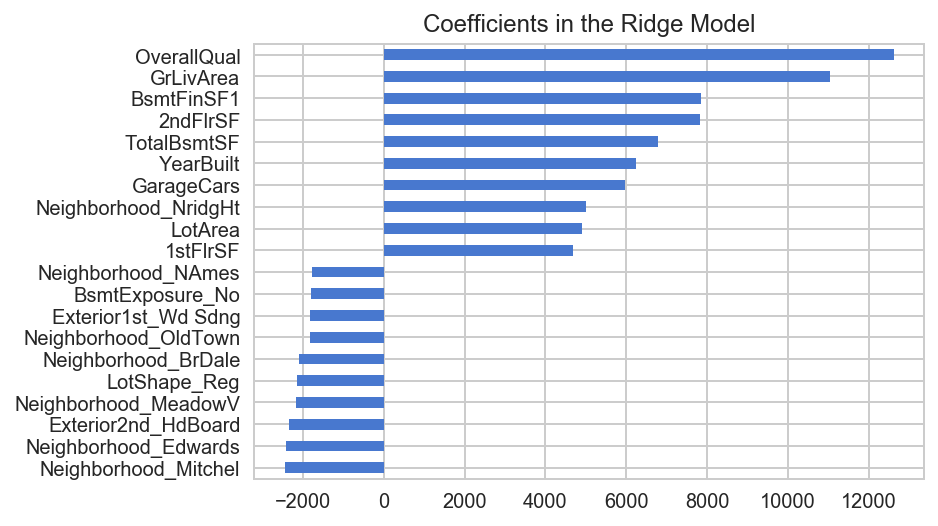

In [51]:
# Cross-validate the Ridge regression  R2R2  with the optimal alpha.

ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(Xs_train, y_train)

ridge_scores = cross_val_score(ridge, Xs_train, y_train, cv=10)
ridge_scores2 = cross_val_score(ridge, Xs_test, y_test, cv=10)
print ('Ridge CV (Train):',np.mean(ridge_scores))
print ('Ridge CV (Test):',np.mean(ridge_scores2))

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()


In [52]:
coefs = coefs.sort_values(ascending=False)


# Model 2: Lasso

In [53]:
#Standardising the training set
ss=StandardScaler()
Train_X1s=ss.fit_transform(X_train)
#Feature Selection using Lasso Model
#Finding an optimal value for Lasso regression alpha using LassoCV
las=LassoCV(n_alphas=500)
#coefficients for variables in the Lasso
las.fit(Train_X1s,y_train)
score=cross_val_score(las,Xs_train,y_train,cv=5)
score2=cross_val_score(las,Xs_test,y_test,cv=5)
print ('Lasso score Train', score.mean())
print ('Lasso score Test', score2.mean())

laspd_f=pd.DataFrame([before_2010.columns,np.abs(las.coef_)],index=['Features','Scores']).T.sort_values('Scores',ascending=False)


('Lasso score Train', 0.89341428701126213)
('Lasso score Test', 0.82528083645900474)


Lasso picked 53 features and eliminated the other 34 features


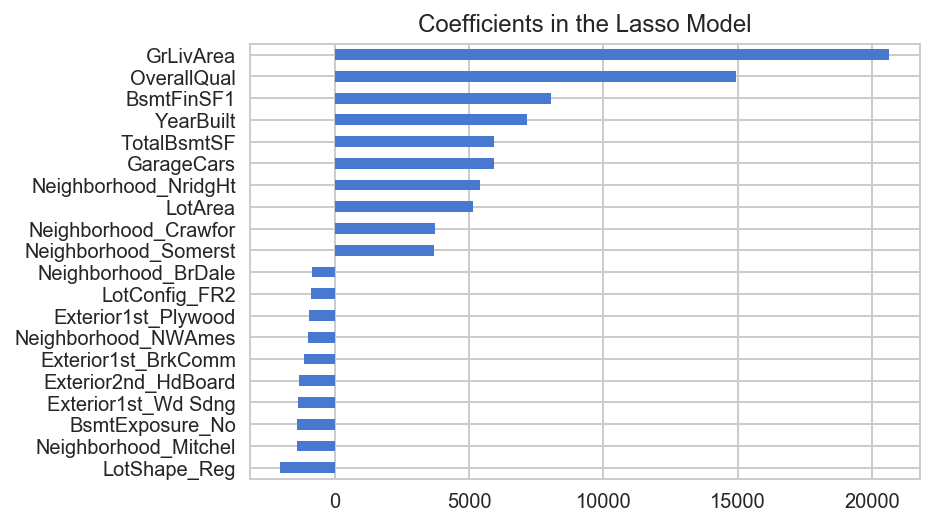

In [54]:
# Plot important coefficients
coefs = pd.Series(las.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

As we can se lasso gives me better scores than the Ridges one. Let's see now what we get with Elastic Net.

# Model 3: Elastic Net

In [55]:
#Finding an optimal value for Elastic Net regression alpha using ElasticNetCV
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs_train, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

.............................................................................................................................................................................................................

364.22767278
1.0


.......[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   27.8s finished


In [56]:
#Cross-validate the ElasticNet  R2R2  with the optimal alpha and l1_ratio

In [57]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs_train, y_train, cv=10)
enet_scores2 = cross_val_score(enet, Xs_test, y_test, cv=10)
print(np.mean(enet_scores))
print(np.mean(enet_scores2))

0.893626176171
0.760253523077


Performs basically the same as Ridge, the best model to use is Lasso.

In [58]:
###### R-Square Results for all types of 
print( "---------------------------------------------------------------------------")
print( "Ridge Regularization:")      
print ('R2 Train:',np.mean(ridge_scores))
print ('R2 Test:',np.mean(ridge_scores2))
print( "---------------------------------------------------------------------------")

print( "Lasso Regularization: ") 
print ('R2 Train', score.mean())
print ('R2 Test', score2.mean())
print( "---------------------------------------------------------------------------")

print( "ElasticNet Regularization: ") 
print('R2 Train',np.mean(enet_scores))
print('R2 Test',np.mean(enet_scores2))
print( "---------------------------------------------------------------------------")      

---------------------------------------------------------------------------
Ridge Regularization:
('R2 Train:', 0.89211624835303405)
('R2 Test:', 0.78392574164839646)
---------------------------------------------------------------------------
Lasso Regularization: 
('R2 Train', 0.89341428701126213)
('R2 Test', 0.82528083645900474)
---------------------------------------------------------------------------
ElasticNet Regularization: 
('R2 Train', 0.89362617617060636)
('R2 Test', 0.76025352307713412)
---------------------------------------------------------------------------


As a result we found that all the regularizations don't give much improvement in r2 original dataset after lasso 

Lasso regularization has better model

In [59]:
#Gets the columns that I will keep for my predictions
Laso_Cols = laspd_f[laspd_f.Scores !=0].Features
len(Laso_Cols)

56

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

first step: run the model again to find the predicted price, then find the differences between the predicted price and the real price = RESIDUAL value that can be predicted using renovateable features.

this residual value will be the target variable for renovatable features

In [60]:
renovateable_columns = ['OverallCond','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
'ExterCond','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',
'Fireplaces','GarageQual','GarageCond', 'SalePrice']

#There are null values in the numercial variables so I will set them in 0
# renovateable_df =house[renovateable_columns]
# reno_dummies = get_dummies(renovateable_df)
# reno_dummies.head()

In [61]:
# Using previous best model to predict saleprice
import sklearn.linear_model
model = grid2 = sklearn.model_selection.GridSearchCV(
    sklearn.linear_model.Lasso(),
    param_grid = { 'alpha' : np.logspace(-10, 100, 2000),
                   'normalize': [True]})

model.fit(fixed_dummies_df[Laso_Cols], renovatable_df.SalePrice)
predict = model.predict(fixed_dummies_df[Laso_Cols])

## Create Residual feature 
renovatable_df['Residual']  = renovatable_df.SalePrice - predict
renovatable_df

NameError: name 'renovatable_df' is not defined

In [ ]:
# create dummy variable for object features
reno_dummies_df=get_dummies(renovatable_df)
reno_dummies_df

In [ ]:
#Drops Saleprice column
reno_dummies_df.drop('SalePrice', axis=1, inplace=True)
reno_dummies_df

In [ ]:
#Residual Distribution 
sns.distplot(reno_dummies_df.Residual)

In [ ]:
#Splits the dataset, in the variable residual we keep the Residual column and we drop it from the reno_dummies dataframe
residual = reno_dummies_df['Residual']
reno_dummies_df.drop('Residual', axis=1, inplace=True)

In [ ]:
len(reno_dummies_df.columns)

In [ ]:
import statsmodels.api as stats
X = reno_dummies_df
y = residual

# Add constant (beta0)
X = stats.add_constant(X) 

#Ordinary Least Squares model
model = stats.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

The model shows the dollar effect of all the renovatable elements of the dataset. The Coefficient illustrates the dollar value change in Residual of one unit change in the variable.We can see here that this model has a R-squared value of 0.224 , meaning that this model explains 22.4% of the variance in our dependent variable.
For OverallCond: Overall condition rating!, every increase equals to a $5213.50 increase in sale price.

I don't trust in this model due to the low R squared. To get a better result, we will need to find new features that
explain better the Residual Value. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: